<a href="https://colab.research.google.com/github/Dunckleosteus/seismic/blob/George/seismic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install bruges

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bruges
import bruges.filters as bf

# Installing files
The csv files are stored in a zip on github, we use the wget command to install the folder and later unzip it.

In [3]:
!rm data.zip
!rm -r data
!wget https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
!unzip data.zip

--2025-03-24 16:40:19--  https://github.com/Dunckleosteus/seismic/raw/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip [following]
--2025-03-24 16:40:19--  https://raw.githubusercontent.com/Dunckleosteus/seismic/18908e9e23b56529c5744c96fac2a5216cd298cd/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1512 (1.5K) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   1.48K  --.-KB/s    in 0s      

2025-03-24 16:40:19 (10.9 MB/s) - ‘da

# Loading data
All the files to be opened are added to a list so that they may be opened one by one. They are later stacked as a multidimentional numpy array to aid computation.

In [4]:

df_path_list = [
    "data/rhob.csv",
    "data/vph.csv",
    "data/x.csv",
    "data/y.csv",
]
df_list = [pd.read_csv(path, index_col=None, header=None, sep=";") for path in df_path_list]
[df.dropna(inplace=True) for df in df_list]
for df in df_list:
  for col in df.columns:
    try:
      df[col] = df[col].str.replace(",", ".").astype(float).values
    except:
      df.values

array = np.stack(df_list)
array.shape

(4, 13, 31)

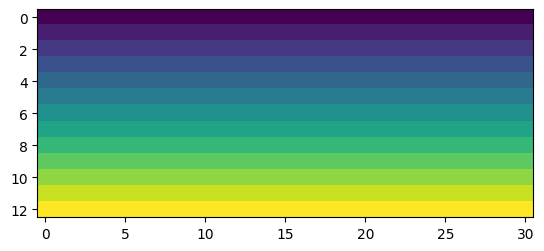

In [5]:
plt.imshow(np.flip(array[3, :, :]))

# Accoustic impedance
The formula for accoustic impedance is :
$$I_i=\rho_i \times v_i$$

So to calculate it, we simply need to multiply the first layer in array to the second one.

Text(0.5, 1.0, 'Accoustic impedance')

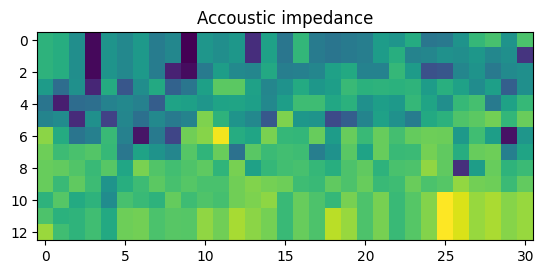

In [6]:
# impedance_matrix = np.flip(array[0, :, :] * array[1, :, :])
impedance_matrix = array[0, :, :] * array[1, :, :]
plt.imshow(impedance_matrix)
plt.title("Accoustic impedance")

# Reflection coefficient
$$R_o=\frac{I_{i+1}-I_i}{I_{i+1}+I_i}$$
Where I is the impedance calculated above.

This operation is 1D and is deployed on vertical axis. Here are vertical axis is represented by y.

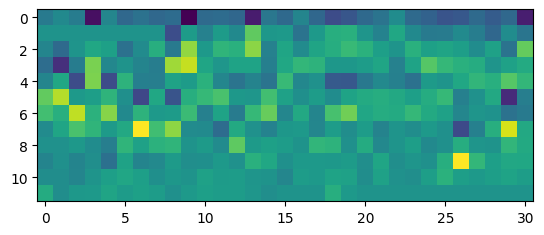

In [7]:
I     = np.roll(impedance_matrix, shift=1, axis=0)[:-1, :] # n+1
In1  = impedance_matrix[1:, :] # n
reflection_coeff = (In1 - I) / (In1 + I)
plt.imshow(reflection_coeff)

### Convert array matrix to time instead of depth

In [8]:
time_matrix = (0.2 / array[1, :, :])
time_matrix = np.cumsum(time_matrix, axis=0) * 2 # time matrix in seconds

## Fish bone plot
This represents the variations along a given vertical axis.

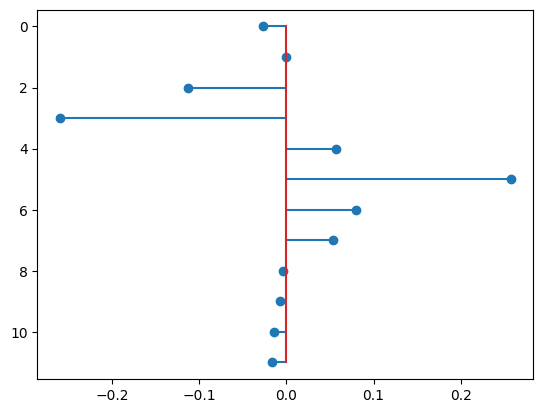

In [9]:
plt.stem(reflection_coeff[:, 1], orientation='horizontal')
plt.gca().invert_yaxis()

# Seismic wavelet

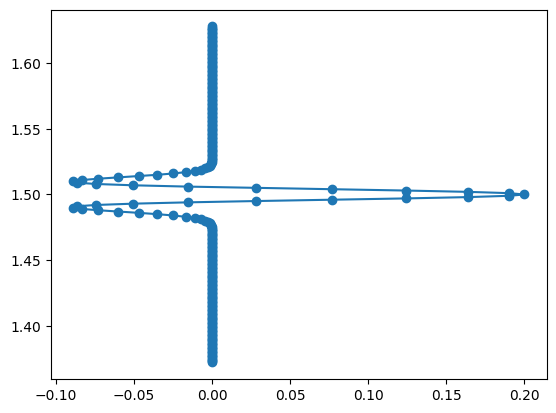

In [10]:

def create_wavelet(offset, amplitude, length=0.256, frequency=40, sample_intervall=0.01):
  w, t = bf.ricker(length, sample_intervall, frequency)
  t += offset
  w *= amplitude
  return w,t

w, t = create_wavelet(1.5, 0.2, sample_intervall=0.001)
plt.plot(w, t)
plt.scatter(w,t )

# Convoluting the wavelet with fishbone


In [11]:
import numpy as np

rc = reflection_coeff[:,1]

"""
The array of wavelets must the the same size for them to be convolved. This function adds 0s to do that.
Inputs:
- arr : numpy array
- target_length(int) : the size the array should be resample to
"""
def expand_with_zeros(arr, target_length): #fill des valeurs manquantes par des 0 pour ne pas modifier la données
    if len(arr) == target_length:
        return arr
    new_arr = np.zeros(target_length)
    indices = np.linspace(0, target_length - 1, len(arr), dtype=int)            # create correct size matrix of 0
    for i, index in enumerate(indices):                                         # fill the matrix with values of initial matrix @ correct index
        new_arr[index] = arr[i]
    return list(new_arr)

def equalize_arrays(arr1, arr2): #faire en sorte que les deux arrays aient le meme nombre de points
    max_length = max(len(arr1), len(arr2))

    arr1_expanded = expand_with_zeros(arr1, max_length)
    arr2_expanded = expand_with_zeros(arr2, max_length)

    return arr1_expanded, arr2_expanded



rc2, w2 = equalize_arrays(rc, w)

syn = np.convolve(rc2, w2, mode='same')



## Plotting wavelet for each column

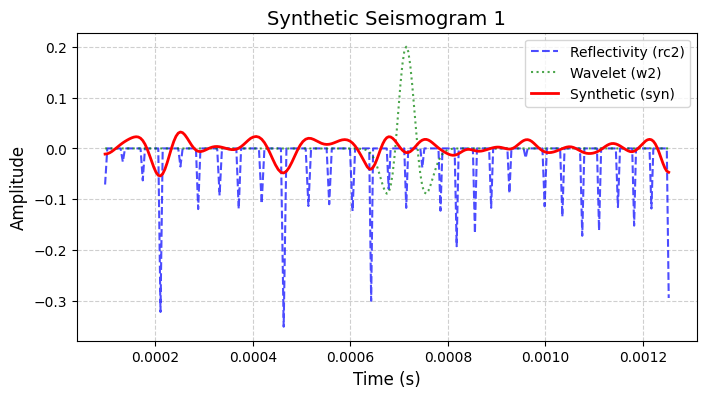

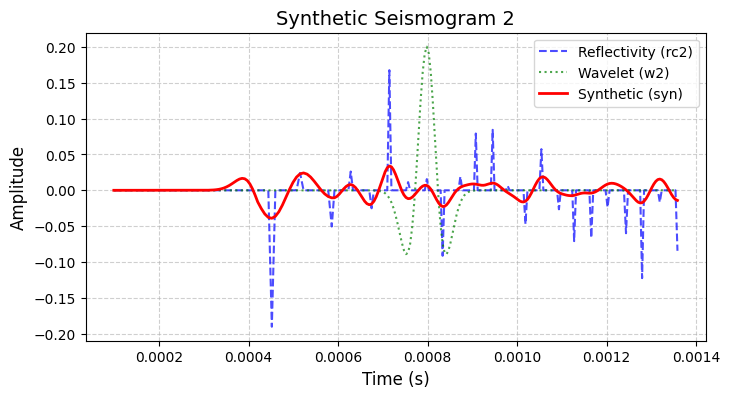

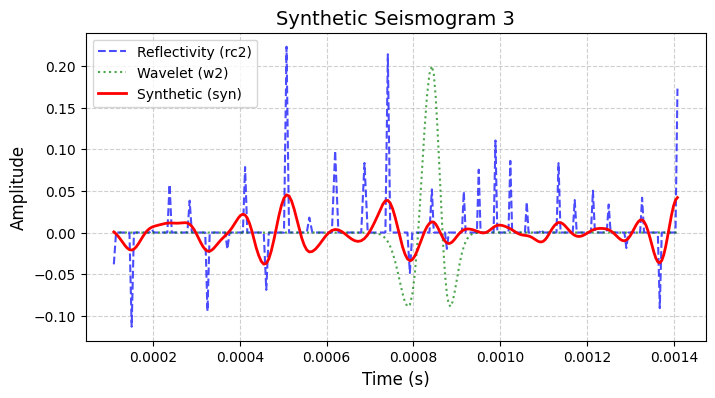

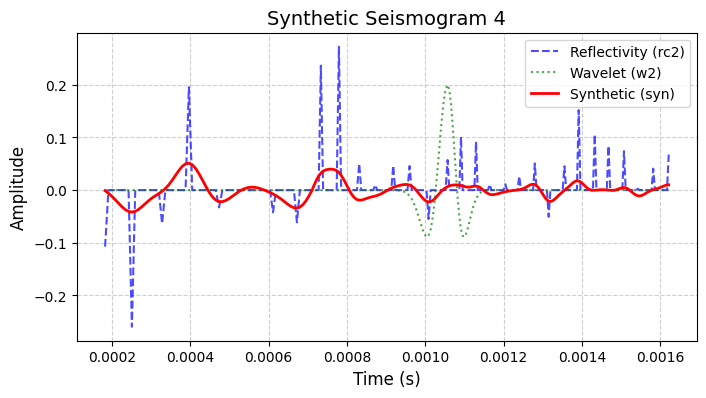

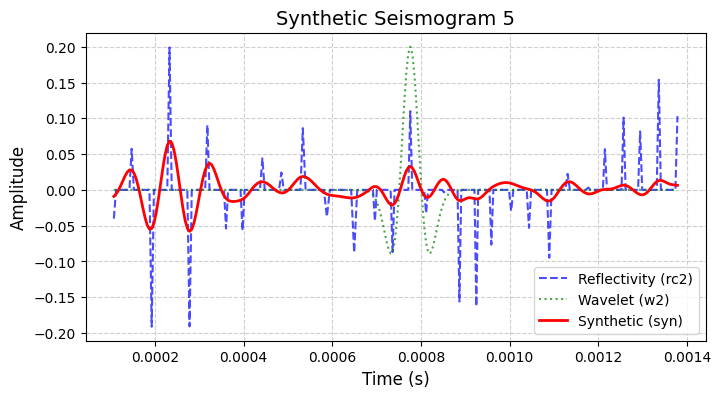

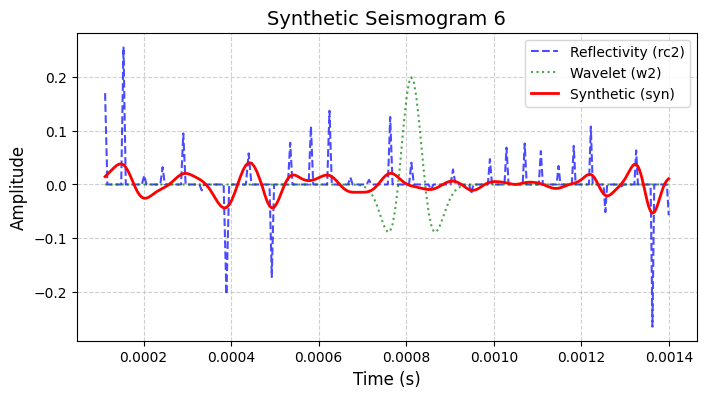

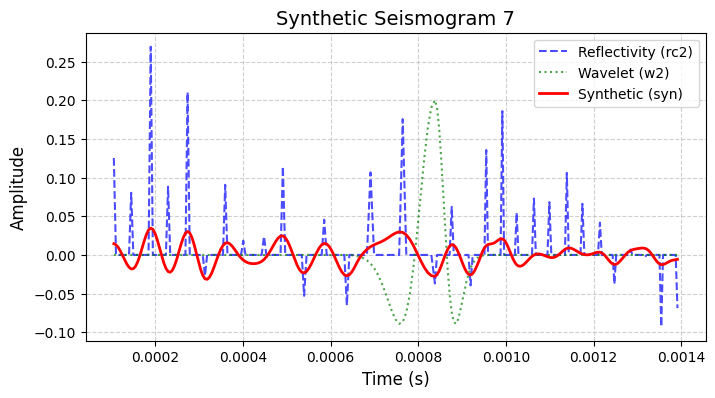

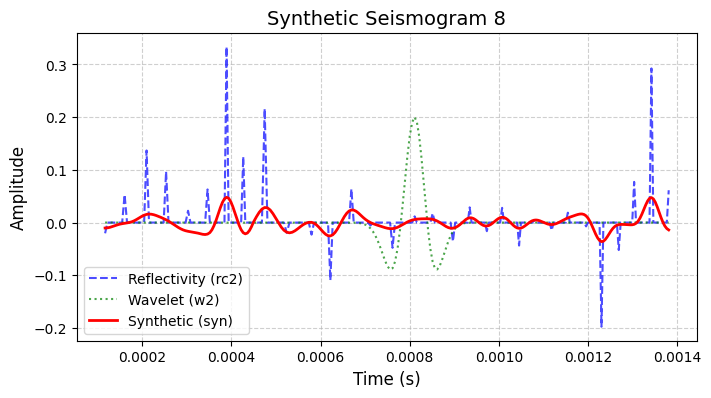

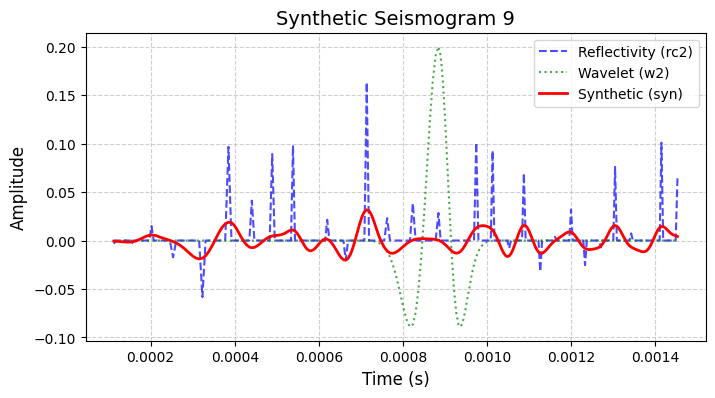

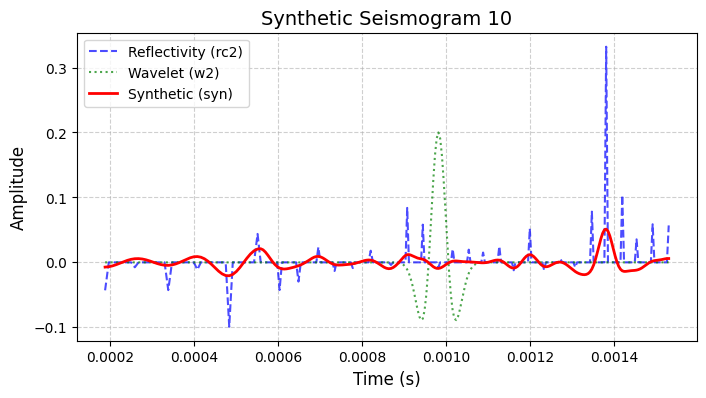

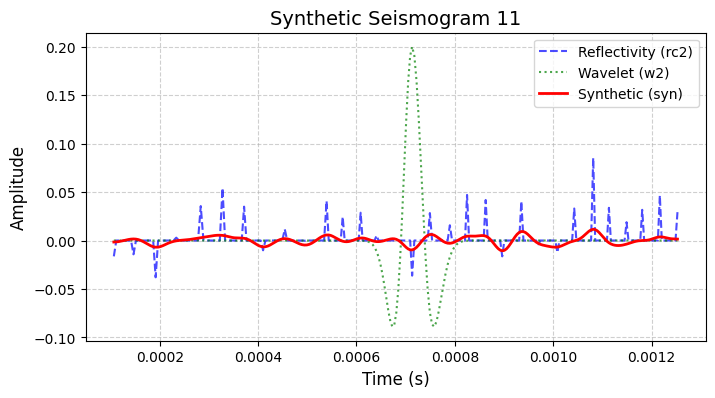

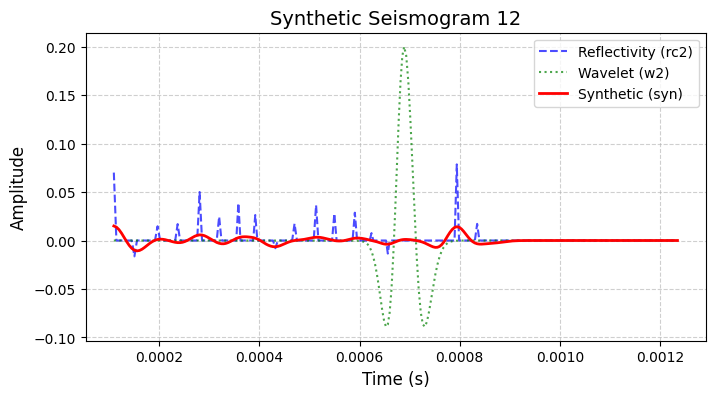

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs
    syn = np.convolve(rc2, w2, mode='same')  # Convolution

    # Extraction du temps correspondant à rc
    time_original = time_matrix[:, i]  # Temps original pour cette trace

    # Vérification de la taille de time_matrix
    if len(time_original) != len(rc2):
        # Interpolation linéaire pour rééchantillonner le temps
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    # Création d'une nouvelle figure
    plt.figure(figsize=(8, 4))

    # Tracé des courbes avec time_matrix sur l'axe des x
    plt.plot(time_resampled, rc2, label='Reflectivity (rc2)', color='b', linestyle='dashed', alpha=0.7)
    plt.plot(time_resampled, w2, label='Wavelet (w2)', color='g', linestyle='dotted', alpha=0.7)
    plt.plot(time_resampled, syn, label='Synthetic (syn)', color='r', linewidth=2)

    # Ajout de titre et légende
    plt.title(f'Synthetic Seismogram {i+1}', fontsize=14)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Affichage
    plt.show()


## All convolution
Plotting the result of all the convolutions.

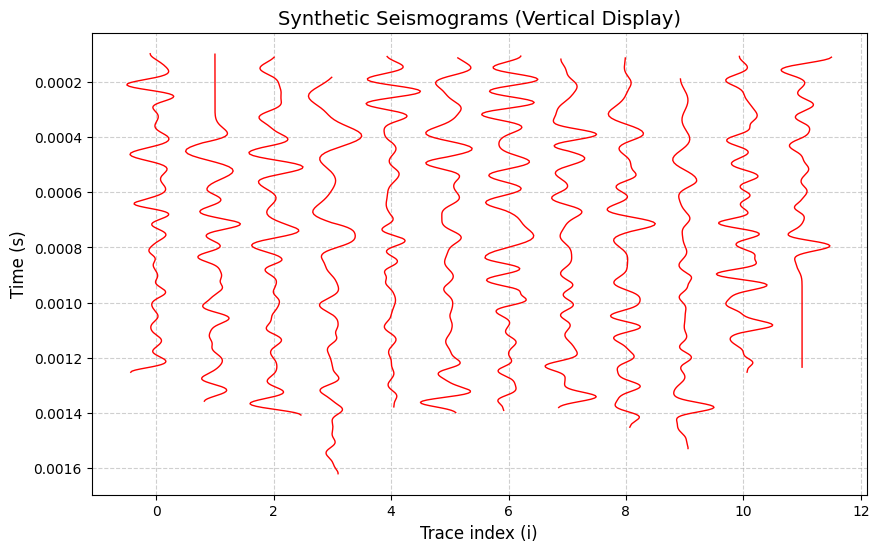

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

plt.figure(figsize=(10, 6))  # Taille du graphique
traces = []
rc_list = []
for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # Égalisation des longueurs


    syn = np.convolve(rc2, w2, mode='same')  # Convolution
    traces.append(syn)
    # Extraction du temps correspondant à rc
    time_original = time_matrix[:, i]
    rc_list.append(time_original)

    # Vérification et interpolation du temps si nécessaire
    if len(time_original) != len(rc2):
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    # Normalisation et recentrage de syn autour de X = i
    syn_norm = syn / np.max(np.abs(syn)) * 0.5  # Mise à l'échelle pour éviter le chevauchement
    x_values = syn_norm + i  # Décalage en X pour l'alignement

    # Tracé du sismogramme à la verticale
    plt.plot(x_values, time_resampled, color='r', linewidth=1)

# Personnalisation du plot
plt.gca().invert_yaxis()  # Mettre l'origine du temps en haut
plt.xlabel('Trace index (i)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Synthetic Seismograms (Vertical Display)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)

# Affichage
plt.show()


![image.png]( )

# Creating pandas dataframe from seismic data
We do this because it's easier to filter data, furthermore the distance and time data are simply added to different columns wich makes switching from depth to time plots easier.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d



x_values_list = [] # stores x values == columns
amplitude_list = [] # amplitude of points
time_list = [] # time distance in y
distances = [] # distances in y as well

for i, rc in enumerate(reflection_coeff):
    rc2, w2 = equalize_arrays(rc, w)  # make sure arrays are same length
    syn = np.convolve(rc2, w2, mode='same')  # use numpy to convolve just like above

    dist = array[3, :, i]
    time_original = time_matrix[:, i]


    if len(time_original) != len(rc2):
        f = interp1d(np.linspace(0, 1, len(time_original)), time_original, kind='linear', fill_value="extrapolate")
        time_resampled = f(np.linspace(0, 1, len(rc2)))
    else:
        time_resampled = time_original

    if len(dist) != len(rc2):
        f_y = interp1d(np.linspace(0, 1, len(dist)), dist, kind='linear', fill_value="extrapolate")
        dist_resampled = f_y(np.linspace(0, 1, len(rc2)))
    else:
        dist_resampled = dist

    syn_norm = syn / np.max(np.abs(syn))  # normalize data

    # data appended to list for dataframe creation
    for amp, t, dist_val in zip(syn_norm, time_resampled, dist_resampled):
        x_values_list.append(i)
        amplitude_list.append(amp)
        time_list.append(t)
        distances.append(dist_val)

# Created dataframe from the lists
data = {
    'x': x_values_list,
    'amplitude': amplitude_list,
    'time': time_list,
    'dept':distances
}
df = pd.DataFrame(data)

df

       x     amplitude      time      dept
0      0 -2.054213e-01  0.000097  2.400000
1      0 -1.944765e-01  0.000102  2.390625
2      0 -1.628415e-01  0.000106  2.381250
3      0 -1.142960e-01  0.000111  2.371875
4      0 -5.420525e-02  0.000115  2.362500
...   ..           ...       ...       ...
3079  11 -1.642205e-54  0.001218  0.037500
3080  11 -9.632645e-56  0.001222  0.028125
3081  11 -5.473202e-57  0.001226  0.018750
3082  11 -3.012434e-58  0.001231  0.009375
3083  11 -1.606111e-59  0.001235  0.000000

[3084 rows x 4 columns]


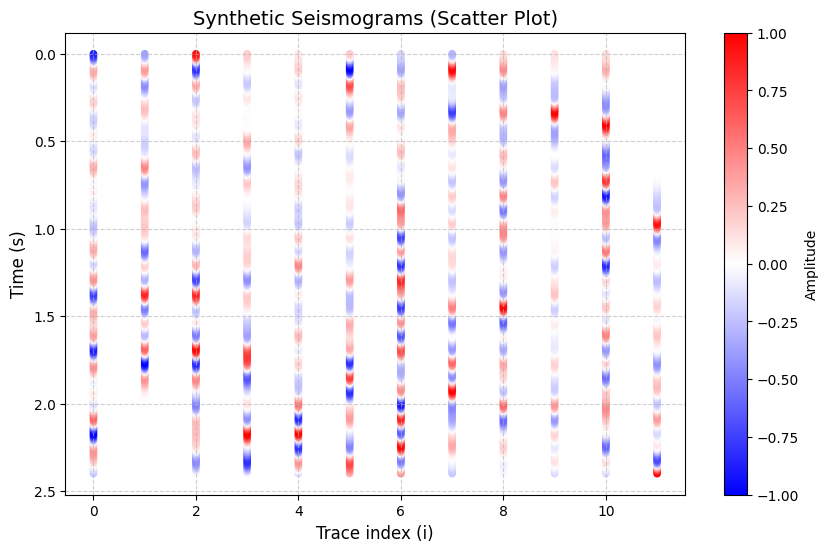

In [16]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['x'], df['dept'], c=df['amplitude'], cmap='bwr', marker='o', s=20)  # Ajustez 's' pour la taille des points
plt.colorbar(sc, label='Amplitude')

# Personnalisation du plot
plt.xlabel('Trace index (i)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Synthetic Seismograms (Scatter Plot)', fontsize=14)
plt.gca().invert_yaxis()  # Mettre l'origine du temps en haut
plt.grid(True, linestyle='--', alpha=0.6)

# Affichage
plt.show()

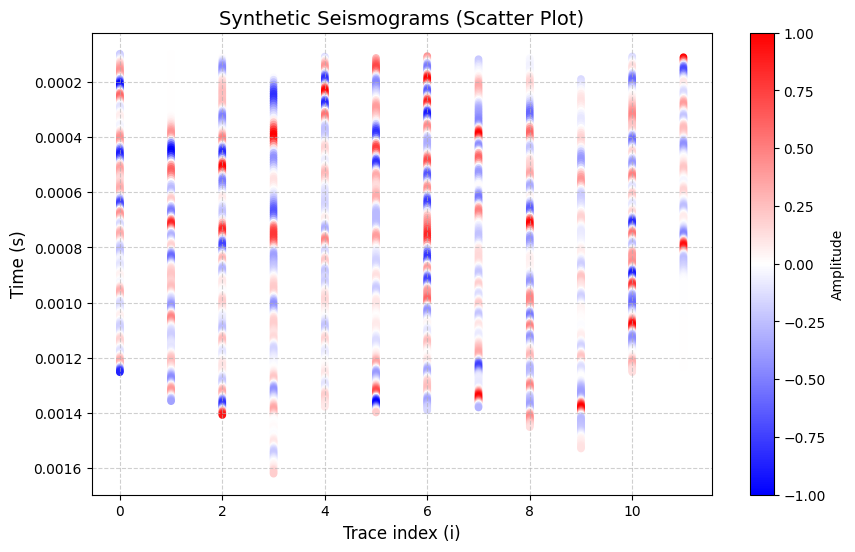

In [17]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df['x'], df['time'], c=df['amplitude'], cmap='bwr', marker='o', s=20)  # Ajustez 's' pour la taille des points
plt.colorbar(sc, label='Amplitude')

# Personnalisation du plot
plt.xlabel('Trace index (i)', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Synthetic Seismograms (Scatter Plot)', fontsize=14)
plt.gca().invert_yaxis()  # Mettre l'origine du temps en haut
plt.grid(True, linestyle='--', alpha=0.6)

# Affichage
plt.show()

# Interpolate

In [18]:
df

,x,amplitude,time,dept
0,0,-2.054213e-01,0.000097,2.400000
1,0,-1.944765e-01,0.000102,2.390625
2,0,-1.628415e-01,0.000106,2.381250
3,0,-1.142960e-01,0.000111,2.371875
4,0,-5.420525e-02,0.000115,2.362500
...,...,...,...,...
3079,11,-1.642205e-54,0.001218,0.037500
3080,11,-9.632645e-56,0.001222,0.028125
3081,11,-5.473202e-57,0.001226,0.018750
3082,11,-3.012434e-58,0.001231,0.009375


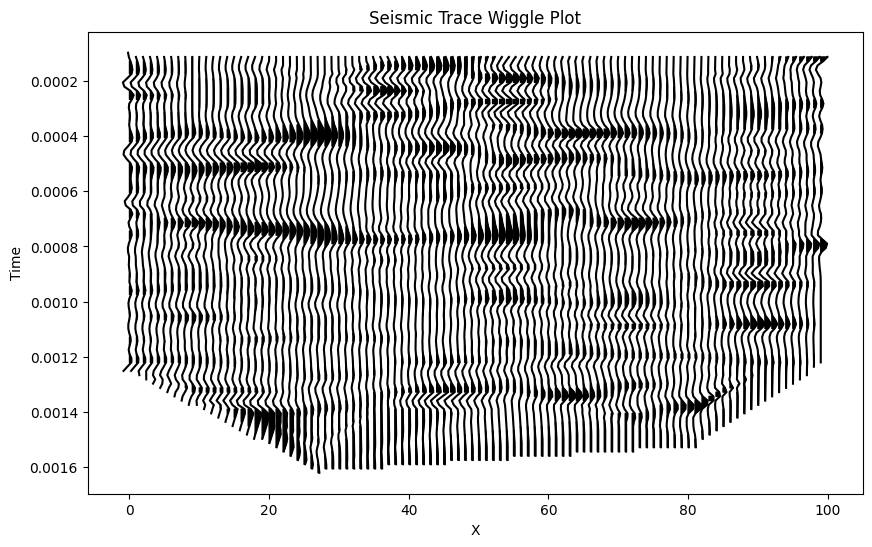

In [19]:
from scipy.interpolate import interp1d
from scipy.interpolate import griddata

# Create an interpolation function
x = df['x'].values
time = df['time'].values
amplitude = df['amplitude'].values

# Create a grid of points for interpolation
xi = np.linspace(x.min(), x.max(), 100)
ti = np.linspace(time.min(), time.max(), 100)
xi, ti = np.meshgrid(xi, ti)

# Perform the 2D interpolation
zi = griddata((x, time), amplitude, (xi, ti), method='linear')

plt.figure(figsize=(10, 6))
for i in range(zi.shape[1]):
    plt.plot(zi[:, i] + i, ti[:, i], 'k')
    plt.fill_betweenx(ti[:, i], zi[:, i] + i, i, where=(zi[:, i] > 0), color='black')

plt.xlabel('X')
plt.ylabel('Time')
plt.title('Seismic Trace Wiggle Plot')
plt.gca().invert_yaxis()  # Invert y-axis to match seismic trace convention
plt.show()

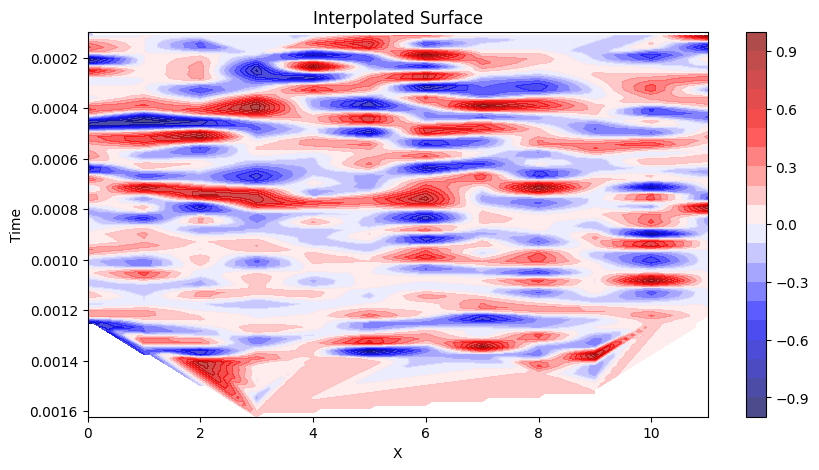

In [20]:

plt.figure(figsize=(10, 5))
plt.contourf(xi, ti, zi, levels=20, cmap='seismic', linestyles="None", alpha=0.7)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Time')
plt.title('Interpolated Surface')
plt.gca().invert_yaxis()  # Invert y-axis to match seismic trace convention
plt.show()

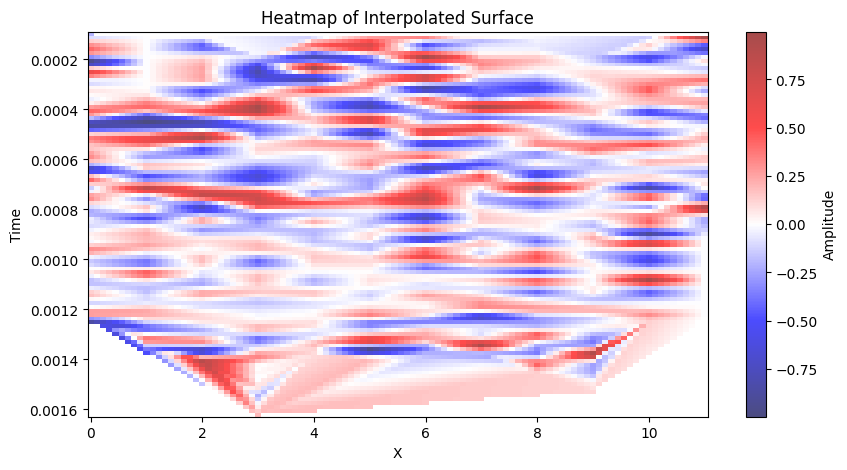

In [21]:
plt.figure(figsize=(10, 5))  # Set the figure size
heatmap = plt.pcolormesh(xi, ti, zi, cmap='seismic', shading='auto', alpha=0.7)  # Adjust alpha for transparency
plt.colorbar(heatmap, label='Amplitude')
plt.xlabel('X')
plt.ylabel('Time')
plt.title('Heatmap of Interpolated Surface')
plt.gca().invert_yaxis()  # Invert y-axis to match seismic trace convention
plt.show()

# Converting seismic to depth

# FInal plot

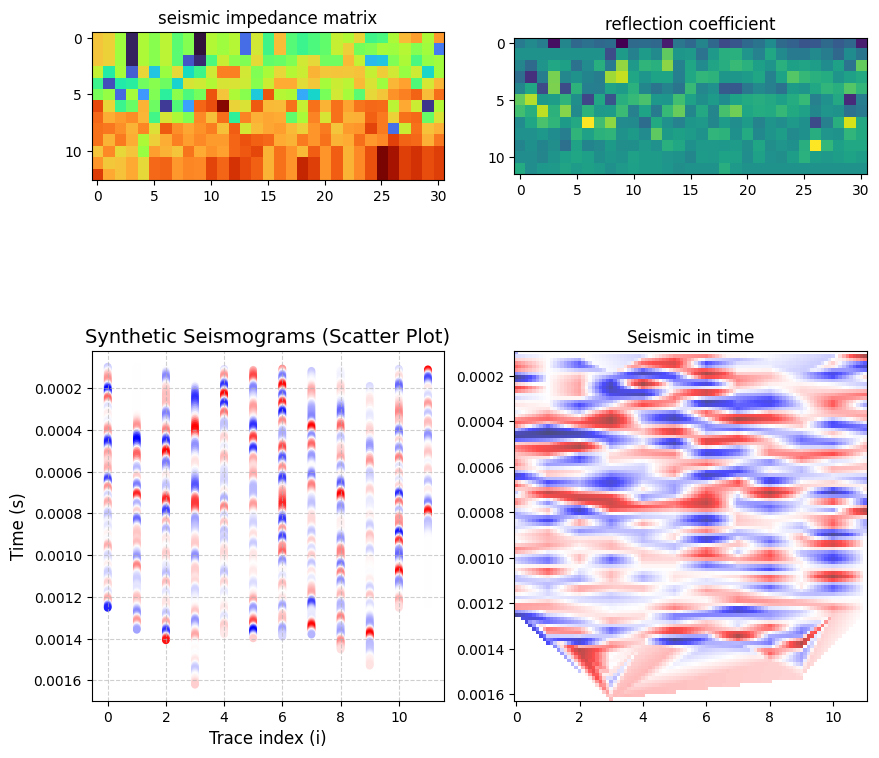

In [22]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize=(10, 10))

# seismic profile
ax[1][1].pcolormesh(xi, ti, zi, cmap='seismic', shading='auto', alpha=0.7)
ax[1][1].set_title("Seismic in time")
ax[1][1].invert_yaxis()
# seismic impedance
ax[0][0].imshow(impedance_matrix, cmap="turbo")
ax[0][0].set_title("seismic impedance matrix")
# reflection coefficient
ax[0][1].set_title("reflection coefficient")
ax[0][1].imshow(reflection_coeff)
# scatter plot
ax[1][0].scatter(df['x'], df['time'], c=df['amplitude'], cmap='bwr', marker='o', s=20)  # Ajustez 's' pour la taille des points
# ax[1][0].colorbar(sc, label='Amplitude')

# Personnalisation du plot
ax[1][0].set_xlabel('Trace index (i)', fontsize=12)
ax[1][0].set_ylabel('Time (s)', fontsize=12)
ax[1][0].set_title('Synthetic Seismograms (Scatter Plot)', fontsize=14)
ax[1][0].invert_yaxis()  # Mettre l'origine du temps en haut
ax[1][0].grid(True, linestyle='--', alpha=0.6)